In [1]:
import pandas as pd

In [52]:
df = pd.read_csv('berlin_bikedata_2017-2019.csv')

In [53]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [54]:
df.set_index('timestamp', inplace=True)

In [55]:
df

,station,total_bikes,hour,hour_str,weekday,day_name,month,month_name,year,description,lat,lon
timestamp,,,,,,,,,,,,
2017-01-01 00:00:00,02-MI-JAN-N,6,0,0 Uhr,6,Sunday,1,January,2017,Jannowitzbrücke Nord,52.513932,13.417835
2017-01-01 00:00:00,02-MI-JAN-S,5,0,0 Uhr,6,Sunday,1,January,2017,Jannowitzbrücke Süd,52.513943,13.417611
2017-01-01 00:00:00,03-MI-SAN-O,4,0,0 Uhr,6,Sunday,1,January,2017,Invalidenstraße Ost,52.527177,13.372016
2017-01-01 00:00:00,03-MI-SAN-W,5,0,0 Uhr,6,Sunday,1,January,2017,Invalidenstraße West,52.527686,13.373105
2017-01-01 00:00:00,05-FK-OBB-O,16,0,0 Uhr,6,Sunday,1,January,2017,Oberbaumbrücke Ost,52.501199,13.445060
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:00:00,21-NK-MAY,34,23,23 Uhr,1,Tuesday,12,December,2019,Maybachufer,52.493000,13.429000
2019-12-31 23:00:00,23-TK-KAI,6,23,23 Uhr,1,Tuesday,12,December,2019,Kaisersteg,52.457270,13.518700
2019-12-31 23:00:00,24-MH-ALB,0,23,23 Uhr,1,Tuesday,12,December,2019,Alberichstraße,52.492500,13.558490


<AxesSubplot:ylabel='description'>

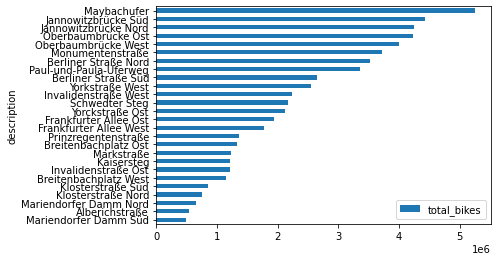

In [56]:
df.groupby('description')[['total_bikes']].sum().sort_values('total_bikes').plot.barh()

In [57]:
total_bikes_2018 = df[df.index.year.isin([2018])].groupby('description')[['total_bikes']].sum().sort_values('total_bikes', ascending=True)
sum_total_bikes_2018 = total_bikes_2018.groupby('description')[['total_bikes']].sum().sum()
sum_total_bikes_2018

total_bikes    21369545
dtype: int64

In [58]:
total_bikes_2019 = df[df.index.year.isin([2019])].groupby('description')[['total_bikes']].sum().sort_values('total_bikes', ascending=True)
total_bikes_2019

,total_bikes
description,
Invalidenstraße Ost,110470
Mariendorfer Damm Süd,171664
Alberichstraße,177604
Mariendorfer Damm Nord,201213
Klosterstraße Nord,261634
Klosterstraße Süd,280432
Breitenbachplatz West,340198
Yorckstraße Ost,355791
Prinzregentenstraße,443086


In [59]:
import plotly.express as px

px.defaults.template = "ggplot2"
px.defaults.color_continuous_scale = px.colors.sequential.Plasma_r

fig = px.bar(total_bikes_2019.reset_index(), x="total_bikes", y="description", color="total_bikes", orientation='h', labels={"total_bikes": "Total Bikes", "description": "Bicycle Counter"})
fig.show()


In [60]:
sum_total_bikes_2019 = total_bikes_2019.groupby('description')[['total_bikes']].sum().sum()
sum_total_bikes_2019

total_bikes    18024377
dtype: int64

In [61]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Indicator(
    mode = "number+delta",
    value = int(sum_total_bikes_2019),
    domain = {'row': 0, 'column': 1}))
# fig.add_trace(go.Indicator(
#     mode = "delta",
#     value = 1000000,
#     domain = {'row': 1, 'column': 1}))
fig.update_layout(
    grid = {'rows': 1, 'columns': 1, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'title': {'text': "Total Bikes"},
        'mode' : "number+delta+gauge",
        'delta' : {'reference': int(sum_total_bikes_2018)}}]
                         }})

In [32]:
average_bike_count = df[df.index.year.isin([2019, 2018])].groupby('description')[['total_bikes']].resample('D').sum().reset_index().groupby('description')[['total_bikes']].mean().sort_values('total_bikes', ascending=True)
average_bike_count

,total_bikes
description,
Mariendorfer Damm Süd,473.934247
Alberichstraße,501.246575
Mariendorfer Damm Nord,592.220548
Klosterstraße Nord,706.713699
Klosterstraße Süd,773.846575
Invalidenstraße Ost,882.121918
Breitenbachplatz West,1064.190411
Kaisersteg,1196.626027
Markstraße,1200.904110


In [33]:
px.defaults.template = "ggplot2"
px.defaults.color_continuous_scale = px.colors.sequential.Plasma_r

fig = px.bar(average_bike_count.reset_index(), x="total_bikes", y="description", color="total_bikes", orientation='h', labels={"total_bikes": "Total Bikes", "description": "Bicycle Counter"})
fig.show()